<a href="https://colab.research.google.com/github/Br-alexis73/Face_recognition/blob/master/fr_casia_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'casia-face-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4502072%2F7710309%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240420%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240420T222148Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D63e9d4210e230cac835476e827d8feb252647573aa6956d25737a1a3da52b7a473e3fdbe7b82c96e68971db2ddb6ca22ae18c018ceaa74d4febc534e9c7316e1028a53f2d1b54dbe082940661ae0138f20dbb1ba05603b5ab7eb4c5b5c946e834a42d226bc80372359c5c39db97c76e0a8c2a953cd452d5cf2456505a3e0470c22f8c2c7e0a4b69c72ce722a26232ee46eaad8009f62ccf1fcffb3a38a045e8b3d94a91c23770c2354150d5265447792467bac3814c51de2a5cd35bcc97fec90523ef71d0eca6c5ab496335290f5d1cd8d300cc3c998f180720ce18bab96bf8b98ade4f089df20b2cb707156c8395502a409eaf5ce2d71c1329a078f5c7837e0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 54767121 bytes downloaded
Downloaded and uncompressed: casia-face-dataset
Data source import complete.


In [24]:
import os
import shutil
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

# Set the dataset path to your Kaggle dataset location
dataset_path = '../input/casia-face-dataset/casia dataset'

In [25]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import cv2

# Assuming 'dataset_path' is defined elsewhere and points to the dataset directory

def filter_top_classes(df, num_classes):
    # Group by 'person' and count the images for each
    image_counts = df.groupby('person').size().reset_index(name='counts')
    # Sort by counts and take the top 'num_classes' rows
    top_classes = image_counts.nlargest(num_classes, 'counts')['person']
    # Filter the original DataFrame to keep only the top classes
    return df[df['person'].isin(top_classes)]

# Read the dataset path and create tuples of (person, image_path)
people_data = os.listdir(dataset_path)
people = []
for item in people_data:
    person_images = os.listdir(os.path.join(dataset_path, item))
    for person_image in person_images:
        if person_image.endswith('.jpg'):  # Make sure to only read jpg files
            people.append((item, os.path.join(dataset_path, item, person_image)))

# Create a DataFrame from the list of tuples
people_df = pd.DataFrame(people, columns=['person', 'path'])

# Filter to only include the top N classes
num_classes_desired = 20  # Change this number to 30 or 40 as needed
people_df = filter_top_classes(people_df, num_classes_desired)

# Convert labels to one-hot encoded labels
label_encoder = LabelEncoder()
labels = people_df['person'].values
int_encoded = label_encoder.fit_transform(labels)
y_onehot = to_categorical(int_encoded)

# Correct the size of the images to match the CNN input
im_size = 224

# Initialize lists to store the images and labels
images = []
labels = []

# Load and preprocess the images
for index, row in people_df.iterrows():
    img = cv2.imread(row['path'])
    img = cv2.resize(img, (im_size, im_size))
    images.append(img)
    labels.append(row['person'])

# Convert the lists to numpy arrays and preprocess
images = np.array(images)
images = images.astype('float32') / 255.0

# Shuffle and split the dataset
train_x, test_x, train_y_onehot, test_y_onehot = train_test_split(images, y_onehot, test_size=0.2, random_state=1)

# Now you have train_x, test_x, train_y_onehot, test_y_onehot ready for training the model


In [26]:
num_classes = len(np.unique(labels))

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(im_size, im_size, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the results to feed into a dense layer
    Flatten(),

    # 256 neurons in the fully connected layer
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout for regularization

    # Output layer with one neuron per class
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_1 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                      

In [28]:
print("train_x shape:", train_x.shape)
print("train_y_onehot shape:", train_y_onehot.shape)
print("test_x shape:", test_x.shape)
print("test_y_onehot shape:", test_y_onehot.shape)

train_x shape: (1616, 224, 224, 3)
train_y_onehot shape: (1616, 20)
test_x shape: (404, 224, 224, 3)
test_y_onehot shape: (404, 20)


In [29]:
history = model.fit(
    train_x,
    train_y_onehot,
    epochs=100,
    batch_size=32,
    validation_data=(test_x, test_y_onehot)
)

Epoch 1/100
51/51 [==============================] - 6s 83ms/step - loss: 3.8873 - accuracy: 0.0631 - val_loss: 2.9931 - val_accuracy: 0.0990
Epoch 2/100
51/51 [==============================] - 4s 72ms/step - loss: 2.6464 - accuracy: 0.2203 - val_loss: 2.8823 - val_accuracy: 0.2574
Epoch 3/100
51/51 [==============================] - 4s 72ms/step - loss: 1.8603 - accuracy: 0.4375 - val_loss: 2.4307 - val_accuracy: 0.4183
Epoch 4/100
51/51 [==============================] - 4s 72ms/step - loss: 1.3316 - accuracy: 0.6151 - val_loss: 2.1232 - val_accuracy: 0.5000
Epoch 5/100
51/51 [==============================] - 4s 70ms/step - loss: 0.9323 - accuracy: 0.7079 - val_loss: 1.8711 - val_accuracy: 0.5272
Epoch 6/100
51/51 [==============================] - 4s 80ms/step - loss: 0.6603 - accuracy: 0.8106 - val_loss: 1.6533 - val_accuracy: 0.5520
Epoch 7/100
51/51 [==============================] - 4s 71ms/step - loss: 0.4499 - accuracy: 0.8571 - val_loss: 1.5295 - val_accuracy: 0.5743
Epoch 

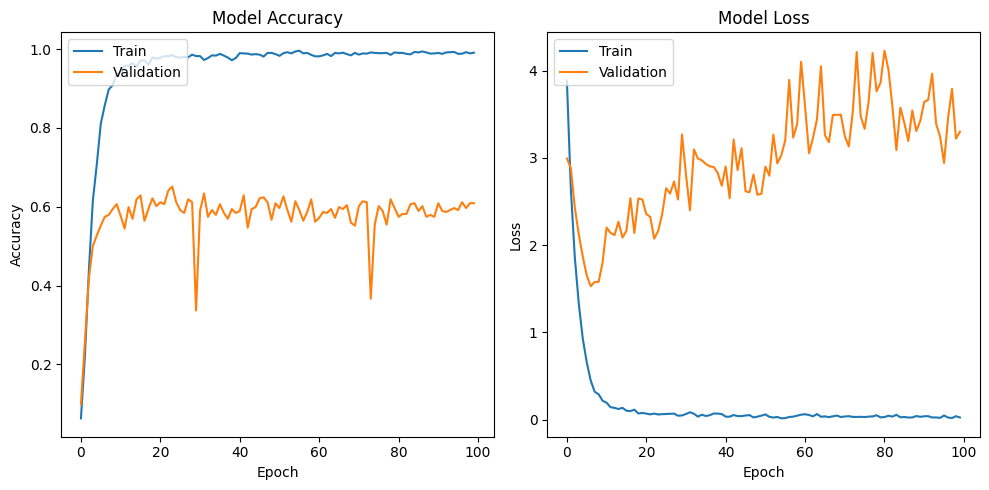

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Now this line is active
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # And this line is active
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [31]:
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

cnn_model = Sequential([
    Conv2D(filters=36, kernel_size=7, activation='relu', input_shape=(im_size, im_size, 3)),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=54, kernel_size=5, activation='relu', input_shape= (im_size, im_size, 3)),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2024, activation='relu'),
     Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output layer with one neuron per class
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',#'categorical_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
)
# Summary of the model
cnn_model.summary()


ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 